In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import matplotlib as plt
import seaborn as sns
from random import randint, choice
from os import path
from main_data import (
    key_to_camelot,
    add_features,
    get_playlist,
    get_friendly,
    json_to_df,
    df_to_json,
    add_features,
    sp,
    get_pods,
)


In [2]:
# Import DataFrames generated by main_data.py
def import_all():
    (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    ) = json_to_df(
        "all_streams.json",
        "music_streams_no_features.json",
        "music_streams.json",
        "no_skip_df.json",
        "playlist_example.json",
        "podcasts.json",
        "wheel_df.json",
    )
    return (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    )


# todo: move to main


def hpm(df, average=None):
    # df["month"] = df.copy().timestamp.dt.month
    df_groupby = (
        df.sort_values(by="month")
        .groupby(["month", pd.Grouper(key="timestamp", freq="Y")])["playtime_h"]
        .sum()
        .groupby("month")
    )
    return df_groupby.mean().sort_index() if average else df_groupby.sum().sort_index()


def plothpm(df_gb):
    df_gb.index = pd.PeriodIndex(df_gb.index, freq="M")
    df_gb = df_gb.sort_index()
    df_gb.index = df_gb.index.strftime("%b")
    # df_gb.index = df_gb.rename(lambda x: x.strftime("%b"))
    return sns.barplot(data=df_gb.iloc[0:0], x=df_gb.index, y=df_gb.values)


def del_skips(deef):
    return deef.query("(playtime_s / duration) > 0.75").reset_index()


def most_played(
    df, years=False, noskips=False, artists=False, album=False, nofeatures=False
):
    # Todo: test against duration
    # Todo: do not allow conflicting params
    # Todo: consider a temporal indexing class
    cols = ["artist", "track", "year"]
    if noskips:
        df = del_skips(df)
    if not years:
        years = df.timestamp.dt.year.unique()
        cols.remove("year")
    if artists:
        cols.remove("track")
    if album:
        cols.remove("track")
        cols.append("album")
    return (
        pd.DataFrame(
            df.query("timestamp.dt.year in @years")
            .pivot_table(columns=cols, aggfunc="size")
            .sort_values(ascending=False)
        )
        .reset_index()
        .rename(columns={0: "count"})
    )


def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


def randyear(df):
    return choice(range(df.timestamp.dt.year.min(), df.timestamp.dt.year.max() + 1))


In [3]:
(
    all_streams,
    music_streams_no_features,
    music_streams,
    no_skip_df,
    playlist_example,
    podcasts,
    wheel_df,
) = import_all()


In [4]:
# To start, I'd like to know how many individual songs I've listened to since July 2019.
len(music_streams["track"].unique())


But how many did I actually listen to?

In [5]:
len(del_skips(music_streams)["track"].unique())


I listen to a lot of music, but I was expecting less.

In [6]:
most_played(podcasts.query("playtime_m > 3"), artists=True, nofeatures=True).head(30).sort_values(by="count", ascending=False)

,artist,count
0,Behind the Bastards,777
1,The Bechdel Cast,286
2,Trillbilly Worker's Party,232
3,Citations Needed,226
4,You're Wrong About,197
5,Revolutions,145
6,Sleepy,132
7,Srsly Wrong,89
8,Worst Year Ever,83
9,Chapo Trap House,65


<AxesSubplot: xlabel='month'>

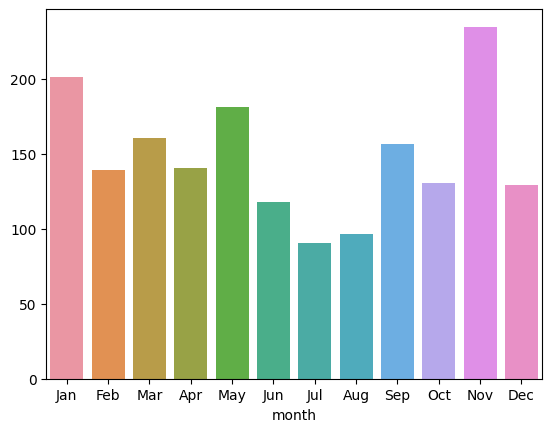

In [7]:
# Mean number of hours listened by month. With my dataset, a raw sum per month would be undesirable, as it spans partial years at the beginning and end.
plothpm(hpm(all_streams, average=True))


In [8]:
# What hours do I spend the most time streaming? Podcasts omitted due to my tendency to use them to fall asleep.
music_streams.loc[:, ["playtime_h", "timestamp"]].groupby(
    by=music_streams.timestamp.dt.tz_localize("UTC").dt.tz_convert("EST").dt.hour
).sum(numeric_only=True).sort_values(by="playtime_h", ascending=False)


,playtime_h
timestamp,
0,216.43
1,211.62
2,198.57
23,194.39
4,176.43
22,175.53
21,173.14
3,171.39
5,160.45


In [9]:
%store -r music_streams

music_streams[music_streams["artist"].str.contains("myNoise") == True]["track"].uni

AttributeError: 'Series' object has no attribute 'uni'

In [ ]:
# Most played songs 2022
most_played(music_streams, noskips=True, years=[2022])


,artist,track,year,count
0,Rvdical the Kid,Nasa,2022,23
1,Pusha T,Brambleton,2022,23
2,Lava La Rue,G.O.Y.D.,2022,22
3,Lava La Rue,Cry Baby,2022,17
4,Billy Lemos,Midlife Crisis,2022,17
...,...,...,...,...
6275,Leikeli47,CIAA,2022,1
6276,Leikeli47,Carry Anne,2022,1
6277,Leikeli47,Done Right,2022,1
6278,Leikeli47,Free To Love,2022,1


In [ ]:
# Top 30 most played tracks over the entire dataset
most_played(music_streams).head(30)


,artist,track,count
0,Teebs,Black Dove,124
1,Hope Tala,Moontime,108
2,Andy Stott,New Romantic,100
3,Dope Saint Jude,Grrrl Like,97
4,Aphex Twin,Alberto Balsalm,94
5,Teebs,Studie,92
6,SUPEREGO,O.B.S (Outer Body Stranger) [feat. Sampa the G...,90
7,Low Leaf,Go Go Go,83
8,Nappy Nina,Treehouse,79
9,Noname,Cherrypie Blues,76


In [ ]:
# Most listened to artists by number of songs played
artists_playtime = most_played(music_streams, artists=True, noskips=True)
artists_playtime


,artist,count
0,Solange,682
1,Teebs,569
2,Frank Ocean,490
3,Noname,475
4,Tim Hecker,463
...,...,...
4187,Pye Corner Audio,1
4188,Puzzle,1
4189,CHLOBOCOP,1
4190,CRUX,1


In [ ]:
# Total time spent listening to specific albums
pd.pivot_table(
    del_skips(music_streams), values="playtime_h", index=["album"], aggfunc="sum"
).sort_values(by="playtime_h", ascending=False).head(30)


,playtime_h
album,
Anicca,22.09
MAGDALENE,17.78
Blonde,17.67
When I Get Home,17.25
Radio Amor,16.76
Portrait with Firewood,14.82
Couldn't Wait to Tell You...,14.01
Take Me Apart,13.37
It Should Be Us,11.19


In [ ]:
# Total amount of songs listened to from individual albums
most_played(music_streams, noskips=True, album=True).head(30)


,artist,album,count
0,Solange,When I Get Home,478
1,Teebs,Anicca,403
2,Liv.e,Couldn't Wait to Tell You...,351
3,J Dilla,Donuts,292
4,Frank Ocean,Blonde,286
5,FKA twigs,MAGDALENE,241
6,keiyaA,"Forever, Ya Girl",217
7,Kelela,Take Me Apart,210
8,Isaiah Rashad,The House Is Burning,206
9,Madvillain,Madvillainy,195


In [ ]:
# Artists I have played the most songs by
most_played(music_streams, artists=True)


,artist,count
0,Solange,794
1,Teebs,679
2,Frank Ocean,650
3,Noname,580
4,Aphex Twin,566
...,...,...
7578,Karol Conká,1
7579,Priori,1
7580,Karma Fields,1
7581,Problem,1


In [ ]:
# Artists I have spent the most aggregate time listening to
repeated_artists = (
    pd.pivot_table(
        del_skips(music_streams), values="playtime_h", index=["artist"], aggfunc="sum"
    )
    .sort_values(by="playtime_h", ascending=False)
    .reset_index()[:1750]
)
repeated_artists.head(30)


,artist,playtime_h
0,Tim Hecker,38.10
1,Andy Stott,37.01
2,Aphex Twin,34.42
3,Teebs,30.38
4,Frank Ocean,30.28
5,Solange,28.83
6,DjRUM,24.71
7,Noname,23.44
8,Ludwig van Beethoven,22.83
9,Miles Davis,21.48


Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should seek more songs from, and/or artists with very long average song lengths.


In [ ]:
# Count number of unique tracks per artist and create ascending list
unique_songs = (
    del_skips(music_streams)
    .query("artist in @repeated_artists['artist']")
    .groupby("artist")
    .apply(lambda x: x["track"].unique())
    .reset_index(name="unique_titles")[:1750]
)


In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should seek more songs from, and/or artists with very long average song lengths.
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()
unique_songs = (
    unique_songs.sort_values(by="unique_count")
    .reset_index()
    .query("unique_count <= 8")["artist"]
)
repeated_artists.query("playtime_h > 1").query("artist in @unique_songs")


,artist,playtime_h
159,Fela Kuti,3.97
187,Jojo Abot,3.54
199,Dope Saint Jude,3.34
202,SUPEREGO,3.32
210,Source Direct,3.21
...,...,...
557,Khalab,1.03
559,박혜진 Park Hye Jin,1.03
560,Dälek,1.03
562,Helado Negro,1.02


Total playtime per month:

<AxesSubplot: ylabel='playtime_h'>

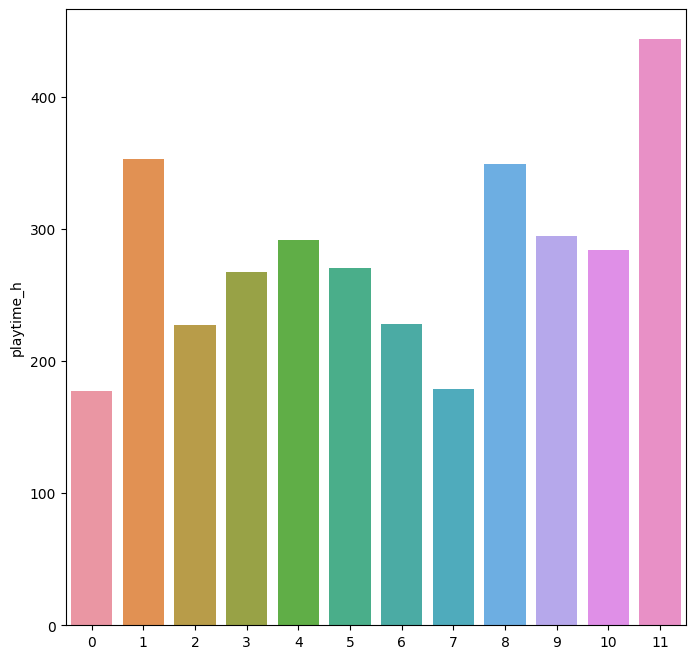

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sns_prep = music_streams
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime_h",
    index=sns_prep.timestamp.dt.strftime("%b"),
    aggfunc="sum",
).reset_index()
sns.barplot(data=sns_prep, x=sns_prep.index, y="playtime_h")


Next, total skips per month. Timestamp is the best way currently implemented to pick out an individual "play" of a track or podcast.

/tmp/ipykernel_11844/4129557215.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sns_prep["count"] = 1


<AxesSubplot: xlabel='month', ylabel='count'>

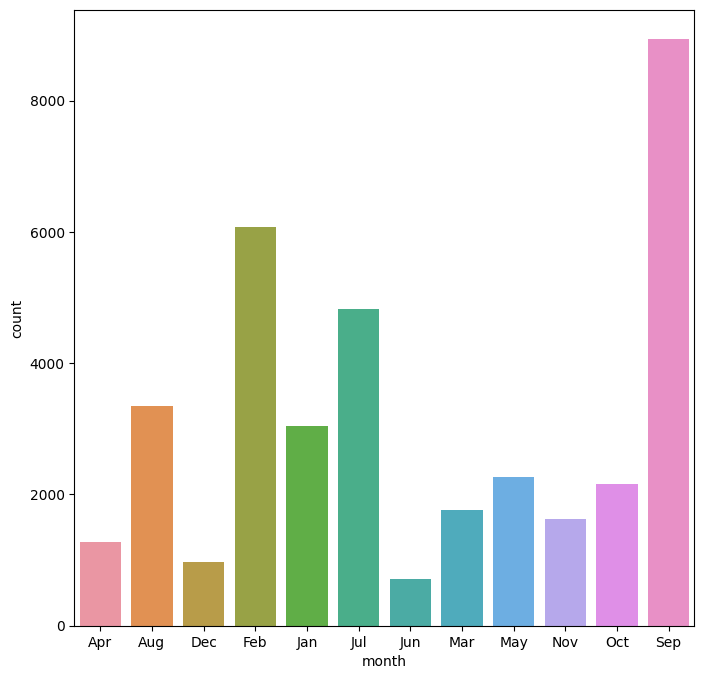

In [ ]:
diff = music_streams["timestamp"][
    ~music_streams["timestamp"].isin(del_skips(music_streams)["timestamp"])
]
sns_prep = music_streams.query("timestamp in @diff")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "playtime_h", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")  # Todo: use plothpm() for this


In [ ]:
# common keys of listened tracks
del_skips(music_streams).loc[:, "timestamp"] = del_skips(music_streams).loc[
    :, "timestamp"
]
pivot_track = pd.DataFrame(
    del_skips(music_streams)
    .drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


/tmp/ipykernel_11844/3470456329.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  del_skips(music_streams).loc[:, "timestamp"] = del_skips(music_streams).loc[


,0
key_signature,
D-flat major,5440
G major,3363
C major,3311
B-flat minor,2851
D major,2742
B minor,2365
F minor,2270
A-flat major,2264
E minor,2104


This function shows every track with harmonically compatible key signatures to the track matching the passed URI. Documentation to follow in further updates.

In [ ]:
get_friendly(
    music_streams, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


,index,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
16628,66603,Aphex Twin,#13,Selected Ambient Works Volume II,440,7.33,2020-08-12,Wed,Aug,2020,135,4A,F minor,False,7c4lnS1bSj4fRJWAQ8D54R,2020-08-12 09:42:43,440,0.12
2505,20035,Aphex Twin,#24,Selected Ambient Works Volume II,342,5.70,2019-12-27,Fri,Dec,2019,138,3B,D-flat major,False,0gZzXPfSknP68aZ5sfyVUH,2019-12-28 02:03:14,342,0.10
30156,84604,Thelonious Monk,'Round Midnight,The Complete Blue Note Recordings,192,3.20,2019-11-25,Mon,Nov,2019,119,4A,F minor,False,5fMZdrFptNIunq8QvofowF,2019-11-25 10:59:07,192,0.05
26446,80559,Rare Silk,'Round Midnight,American Eyes,145,0.20,2021-09-04,Sat,Sep,2021,126,2A,E-flat minor,False,363Z97AXyErxvgowae8qB5,2021-09-04 06:02:12,12,0.00
7704,44719,Thelonious Monk Quartet,'Round Midnight,Misterioso [Original Jazz Classics Remasters],378,2.88,2022-02-18,Fri,Feb,2022,136,2A,E-flat minor,False,5wBkOjOd8mpN8NVSCt155l,2022-02-18 10:28:52,173,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,18449,betcover!!,二限の窓,時間,253,4.22,2021-10-28,Thu,Oct,2021,122,3A,B-flat minor,False,38nSGcLUTfu3cH0zu6F2jL,2021-10-28 20:09:11,253,0.07
10911,54154,Tzusing,日出東方 唯我不敗,東方不敗,312,1.08,2021-09-13,Mon,Sep,2021,120,2B,F-sharp major,False,7A1d0qBQL2IiDhrDrhUqE8,2021-09-13 06:07:05,65,0.02
23888,77459,DJ Trystero,水害,High Speed Wind,376,6.27,2022-07-09,Sat,Jul,2022,120,3B,D-flat major,False,27F1Yx7hW1Oez3wc67l9TI,2022-07-10 00:48:51,376,0.10
11336,55258,DJ Trystero,酒気,High Speed Wind,257,4.28,2022-07-09,Sat,Jul,2022,120,3B,D-flat major,False,5HjXB5FtiFZYxXJxCqMjIF,2022-07-10 01:03:42,257,0.07


In the next cell, I query for days where I played songs with "birthday" in the name. It turns out I definitely mostly play songs with "birthday" in the title on or around the birthdays of my friends and family members.

In [ ]:
music_streams.query("(playtime_s / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
76549,2 Chainz,Birthday Song,Based On A T.R.U. Story,307,4.93,2022-04-17,Sun,Apr,2022,140,3B,D-flat major,False,5qkWTBmDmZjogwIvbKtJQv,2022-04-17 10:53:28,296,0.08
12012,Trap Beckham,Birthday Bitch,Birthday Bitch,197,1.03,2021-08-13,Fri,Aug,2021,102,8B,C major,False,4ZFtNZuzzdHjYKARA8TEh2,2021-08-13 08:02:48,62,0.02
19250,Disclosure,Birthday,Birthday,220,2.02,2021-08-13,Fri,Aug,2021,136,4A,F minor,False,2jCSd2lOtWQKtwb7FdfvPQ,2021-08-13 08:07:33,121,0.03
29817,Happy Birthday,Happy Birthday Reggae,10 Happy Birthday Different Styles,98,0.48,2021-08-13,Fri,Aug,2021,110,6B,B-flat major,False,6ZEdAuCh2shaf3E3rrtHAp,2021-08-13 08:18:19,29,0.01
32799,Happy Birthday,Happy Birthday Funk,10 Happy Birthday Different Styles,82,0.85,2021-08-13,Fri,Aug,2021,100,7B,F major,True,2ShnbhqZMChTitBB2AQrVO,2021-08-13 08:20:25,51,0.01
59952,Happy Birthday,Happy Birthday Jazz,10 Happy Birthday Different Styles,110,0.38,2021-08-13,Fri,Aug,2021,120,7B,F major,True,4GeaHbsPgGR1xMPynrPvy5,2021-08-13 08:20:51,23,0.01
61622,Happy Birthday,Happy Birthday Country,10 Happy Birthday Different Styles,57,0.65,2021-08-13,Fri,Aug,2021,78,8B,C major,True,23X23yCXz1mjeDuRJPfTWm,2021-08-13 08:24:08,39,0.01
62510,Migos,Birthday,Culture III,227,0.45,2021-08-13,Fri,Aug,2021,170,5A,C minor,False,7tt5I7ztXfKzZRqyL2FCYb,2021-08-13 08:11:06,27,0.01
67504,Happy Birthday,Happy Birthday EDM,10 Happy Birthday Different Styles,65,0.88,2021-08-13,Fri,Aug,2021,130,11B,A major,False,4iP9axs07uXTxJiAr1l1rX,2021-08-13 08:17:48,53,0.01
69214,Twista,Birthday,Category F5,221,0.90,2021-08-13,Fri,Aug,2021,110,3A,B-flat minor,False,1tXZ25p92QkW2Oj7ElF4pA,2021-08-13 08:16:30,54,0.02


<AxesSubplot: xlabel='month'>

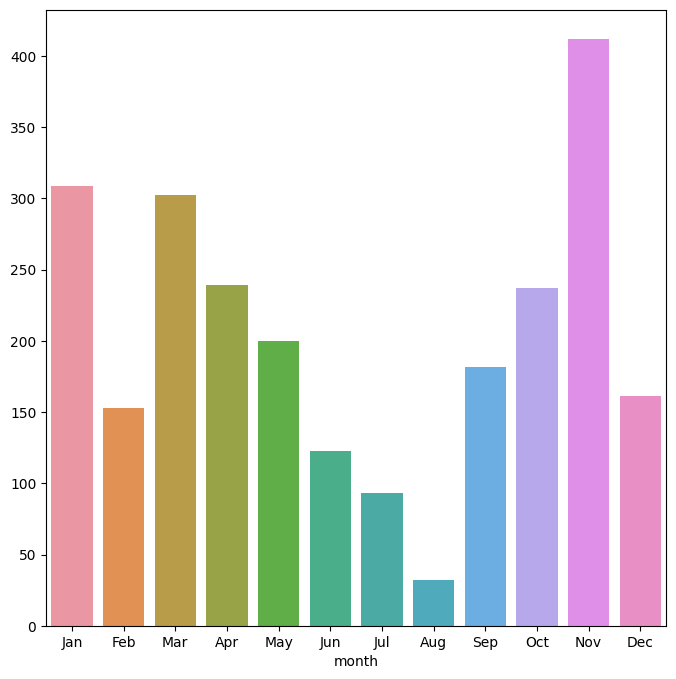

In [ ]:
plothpm(hpm(podcasts))


<AxesSubplot: xlabel='month'>

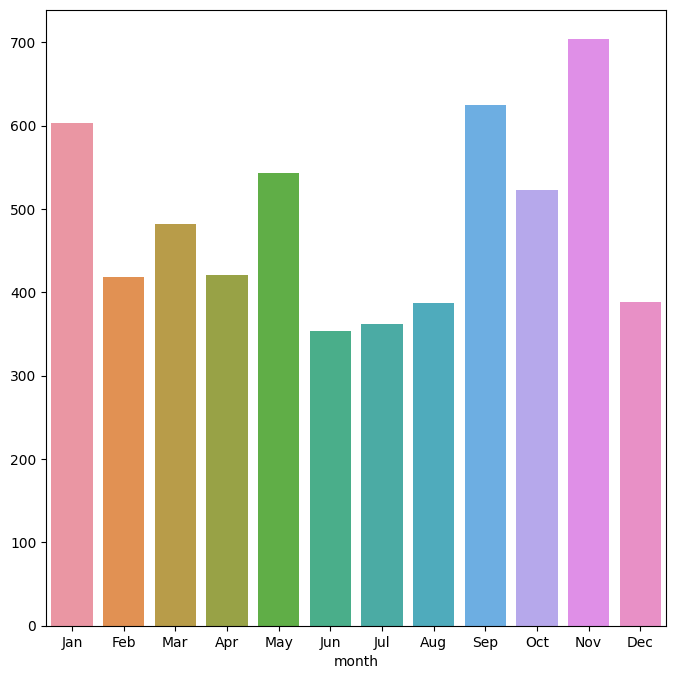

In [ ]:
# Todo: plot podcast listening vs music listening

plothpm(hpm(all_streams))
